In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
def gaussianFilter(sigma,size):
    a=np.zeros((size,size))
    val=size>>1
    for i in range(size):
        for j in range(size):
            x,y=i-val,j-val
            a[i][j]=getGaussianValue(x,y,sigma)
    return a/np.sum(a)

In [3]:
def getGaussianValue(x,y,sigma):
    exp=-1*((x*x + y*y)/(2*sigma*sigma))
    val=np.power(np.e,exp)
    return val/(2*np.pi*sigma*sigma)

In [4]:
def padding(image,filtersize):
    imagesize=image.shape
    p=(filtersize-1)//2
    a=np.zeros((imagesize[0]+2*p,imagesize[1]+2*p,3),dtype=np.uint8)
    a[p:p+imagesize[0],p:p+imagesize[1]]=image[:,:,:]
    return a

In [5]:
def convolution(image,mask):
    output=np.zeros(image.shape)
    padded=padding(image,mask.shape[0])
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            for k in range(3):
                output[i][j][k]=np.sum(padded[i:i+mask.shape[0],j:j+mask.shape[1],k]*mask)
    return np.rint(output).astype(np.uint8)

In [6]:
def rgbToGrayForFilterSize(image,filtersize):
    image=padding(image,filtersize)
    output=np.zeros(image.shape[:-1])
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            output[i][j]=image[i][j][0]*0.30 + image[i][j][1]*0.59 + image[i][j][0]*0.11
    return np.rint(output).astype(np.uint8)

In [7]:
def sobel(image):
    dx,dy=np.zeros((image.shape[0]-2,image.shape[1]-2)),np.zeros((image.shape[0]-2,image.shape[1]-2))
    dx,dy=dx.astype(np.int64),dy.astype(np.int64)
    horiz=np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    verti=np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    horiz,verti=horiz.astype(np.int64),verti.astype(np.int64)
    for i in range(dx.shape[0]):
        for j in range(dx.shape[1]):
            dx[i][j]=np.sum(image[i:i+3,j:j+3]*horiz)
            dy[i][j]=np.sum(image[i:i+3,j:j+3]*verti)
    return [dx.astype(np.int64),dy.astype(np.int64)]

In [8]:
def nonMaxSupression(Magni,dx,dy):
    output=np.zeros(Magni.shape)
    angle=np.arctan(np.true_divide(dy,dx))*(180/np.pi)
    for i in range(Magni.shape[0]):
        for j in range(Magni.shape[1]):
            if angle[i][j]>=-22.5 and angle[i][j]<=22.5:
                val1,val2=-1,-1
                if j>0:
                    val1=Magni[i][j-1]
                if (j+1)<Magni.shape[1]:
                    val2=Magni[i][j+1]
                if val1<=Magni[i][j] and val2<=Magni[i][j]:
                    output[i][j]=Magni[i][j]
            elif angle[i][j]>=22.5 and angle[i][j]<=67.5:
                val1,val2=-1,-1
                if i>0 and (j+1)<Magni.shape[1]:
                    val1=Magni[i-1][j+1]
                if (i+1)<Magni.shape[0] and j>0:
                    val2=Magni[i+1][j-1]
                if val1<=Magni[i][j] and val2<=Magni[i][j]:
                    output[i][j]=Magni[i][j]
            elif (angle[i][j]>=67.5 and angle[i][j]<=90) or (angle[i][j]>=-90 and angle[i][j]<=-67.5):
                val1,val2=-1,-1
                if i>0:
                    val1=Magni[i-1][j]
                if (i+1)<Magni.shape[0]:
                    val2=Magni[i+1][j]
                if val1<=Magni[i][j] and val2<=Magni[i][j]:
                    output[i][j]=Magni[i][j]
            else:
                val1,val2=-1,-1
                if i>0 and j>0:
                    val1=Magni[i-1][j-1]
                if (i+1)<Magni.shape[0] and (j+1)< Magni.shape[1]:
                    val2=Magni[i+1][j+1]
                if val1<=Magni[i][j] and val2<=Magni[i][j]:
                    output[i][j]=Magni[i][j]
    return output
            

In [9]:
def threshold(image):
    t1=0.01
    t2=0.1
    image=image/np.max(image)
    output=np.zeros(image.shape)
    output[image>t2]=1.0
    weaki,weakj=np.where((image>=t1)&(image<=t2))
    for m in range(len(weaki)):
        i,j=weaki[m],weakj[m]
        if i>0 and j>0 and output[i-1][j-1]>0:
            output[i][j]=1
        if i>0 and j+1<output.shape[1] and output[i-1][j+1]>0:
            output[i][j]=1 
        if i+1<output.shape[0] and j>0 and output[i+1][j-1]>0:
            output[i][j]=1
        if i+1<output.shape[0] and j+1<output.shape[1] and output[i+1][j+1]>0:
            output[i][j]=1
        if i>0 and output[i-1][j]>0:
            output[i][j]=1
        if j>0 and output[i][j-1]>0:
            output[i][j]=1
        if i+1<output.shape[0] and output[i+1][j]>0:
            output[i][j]=1
        if j+1<output.shape[1] and output[i][j+1]>0:
            output[i][j]=1
    return output 

In [10]:
def cannyEdge(image,sigma,filtersize):
    mask=gaussianFilter(2,5)
    smoothimage=convolution(image,mask)
    plt.imshow(smoothimage)
    plt.title('Smoothened Image')
    plt.show()
    gray=rgbToGrayForFilterSize(smoothimage,3)
    plt.imshow(gray,cmap='gray')
    plt.title('Grayscale Image')
    plt.show()
    [dx,dy]=sobel(gray)
    plt.imshow(dx,cmap='gray')
    plt.title('Gx Image')
    plt.show()
    plt.imshow(dy,cmap='gray')
    plt.title('Gy Image')
    plt.show()
    Magni=np.sqrt(dx*dx+dy*dy)
    plt.imshow(Magni,cmap='gray')
    plt.title('Magnitude Image')
    plt.show()
    supp=nonMaxSupression(Magni,dx,dy)
    plt.imshow(supp,cmap='gray')
    plt.title('Non Max Suppression Image')
    plt.show()
    final=threshold(supp)
    plt.imshow(final,cmap='gray')
    plt.title('Hysterisis Thresholded Image')
    plt.show()
    return final
    

In [11]:
image=cv2.imread("./test.png")
image=image[:,:,::-1]

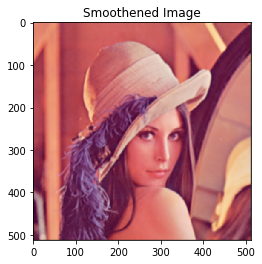

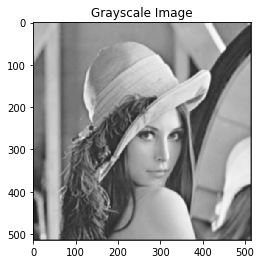

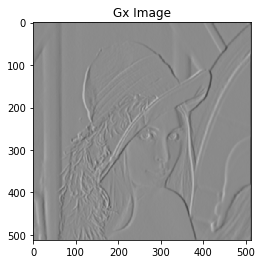

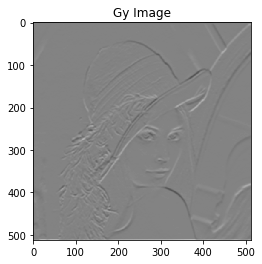

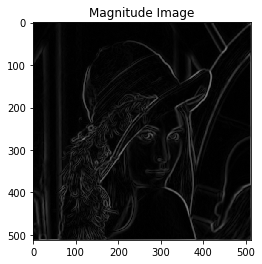

c:\users\sai rathan\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\sai rathan\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


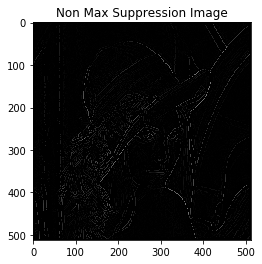

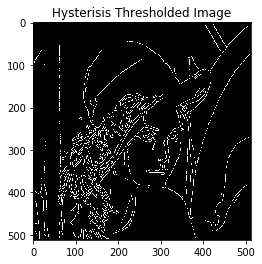

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [12]:
cannyEdge(image,1.5,5)